# Gaussian Mixture Models (EM)
## Experiment 2: GMM on Original Data

This notebook includes:
- GMM implementation from scratch using Expectation-Maximization (EM)
- Support for covariance types: full, tied, diagonal, spherical
- Model selection via BIC and AIC from scratch
- Complete evaluation with internal and external metrics
- Visualizations and analysis of clustering results

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd

sns.set_style('whitegrid')

## GMM Implementation (EM Algorithm)

Define the `GMM_EM` class: initialization, E-step, M-step, log-likelihood, and prediction methods with support for 'full', 'tied', 'diagonal', and 'spherical' covariances.

In [8]:
class GMM_EM:
    def __init__(self, n_components=3, covariance_type='full', max_iter=100, tol=1e-4, random_state=None):
        """
        Gaussian Mixture Model with EM Algorithm
        
        Parameters:
        -----------
        n_components : int
            Number of mixture components
        covariance_type : str
            Type of covariance parameters: 'full', 'tied', 'diagonal', 'spherical'
        max_iter : int
            Maximum number of iterations
        tol : float
            Convergence tolerance
        random_state : int
            Random seed
        """
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
    def initialize_parameters(self, X):
        """Initialize means, covariances, and weights"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Random initialization of means
        random_idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_idx]
        
        # Initialize covariances based on type
        if self.covariance_type == 'full':
            self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        elif self.covariance_type == 'tied':
            self.covariances = np.eye(n_features)
        elif self.covariance_type == 'diagonal':
            self.covariances = np.ones((self.n_components, n_features))
        elif self.covariance_type == 'spherical':
            self.covariances = np.ones(self.n_components)
        
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        
    def _compute_gaussian_prob(self, X, mean, cov):
        """Compute multivariate Gaussian probability with numerical stability"""
        n_features = X.shape[1]
        
        if self.covariance_type == 'full':
            # Add regularization for stability
            cov_reg = cov + np.eye(n_features) * 1e-6
            try:
                return multivariate_normal.pdf(X, mean=mean, cov=cov_reg)
            except:
                # Fallback to manual computation
                diff = X - mean
                cov_inv = np.linalg.inv(cov_reg)
                exp_term = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
                det = np.linalg.det(cov_reg)
                norm = 1.0 / np.sqrt((2 * np.pi) ** n_features * det)
                return norm * np.exp(exp_term)
        
        elif self.covariance_type == 'tied':
            cov_reg = cov + np.eye(n_features) * 1e-6
            return multivariate_normal.pdf(X, mean=mean, cov=cov_reg)
        
        elif self.covariance_type == 'diagonal':
            diff = X - mean
            var = cov + 1e-6
            exp_term = -0.5 * np.sum((diff ** 2) / var, axis=1)
            norm = 1.0 / np.sqrt((2 * np.pi) ** n_features * np.prod(var))
            return norm * np.exp(exp_term)
        
        elif self.covariance_type == 'spherical':
            diff = X - mean
            var = cov + 1e-6
            exp_term = -0.5 * np.sum(diff ** 2, axis=1) / var
            norm = 1.0 / ((2 * np.pi * var) ** (n_features / 2))
            return norm * np.exp(exp_term)
        
    def e_step(self, X):
        """Expectation step: compute responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            if self.covariance_type == 'full':
                cov_k = self.covariances[k]
            elif self.covariance_type == 'tied':
                cov_k = self.covariances
            elif self.covariance_type == 'diagonal':
                cov_k = self.covariances[k]
            elif self.covariance_type == 'spherical':
                cov_k = self.covariances[k]
            
            responsibilities[:, k] = self.weights[k] * self._compute_gaussian_prob(X, self.means[k], cov_k)
        
        # Normalize responsibilities
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum + 1e-10
        
        return responsibilities
    
    def m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        n_samples, n_features = X.shape
        
        # Update means and weights for all types
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            total_resp = resp_k.sum() + 1e-10
            
            # Update weights
            self.weights[k] = total_resp / n_samples
            
            # Update means
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / total_resp
        
        # Update covariances based on type
        if self.covariance_type == 'full':
            for k in range(self.n_components):
                resp_k = responsibilities[:, k]
                total_resp = resp_k.sum() + 1e-10
                diff = X - self.means[k]
                self.covariances[k] = (resp_k[:, np.newaxis, np.newaxis] * 
                                       diff[:, :, np.newaxis] * diff[:, np.newaxis, :]).sum(axis=0) / total_resp
                self.covariances[k] += np.eye(n_features) * 1e-6
        
        elif self.covariance_type == 'tied':
            cov = np.zeros((n_features, n_features))
            for k in range(self.n_components):
                resp_k = responsibilities[:, k]
                diff = X - self.means[k]
                cov += (resp_k[:, np.newaxis, np.newaxis] * 
                        diff[:, :, np.newaxis] * diff[:, np.newaxis, :]).sum(axis=0)
            self.covariances = cov / n_samples + np.eye(n_features) * 1e-6
        
        elif self.covariance_type == 'diagonal':
            for k in range(self.n_components):
                resp_k = responsibilities[:, k]
                total_resp = resp_k.sum() + 1e-10
                diff = X - self.means[k]
                self.covariances[k] = (resp_k[:, np.newaxis] * diff ** 2).sum(axis=0) / total_resp + 1e-6
        
        elif self.covariance_type == 'spherical':
            for k in range(self.n_components):
                resp_k = responsibilities[:, k]
                total_resp = resp_k.sum() + 1e-10
                diff = X - self.means[k]
                self.covariances[k] = np.sum(resp_k[:, np.newaxis] * diff ** 2) / (total_resp * n_features) + 1e-6
    
    def compute_log_likelihood(self, X):
        """Compute log-likelihood of the data"""
        n_samples = X.shape[0]
        log_likelihood = 0.0
        
        for i in range(n_samples):
            sample_likelihood = 0.0
            for k in range(self.n_components):
                if self.covariance_type == 'full':
                    cov_k = self.covariances[k]
                elif self.covariance_type == 'tied':
                    cov_k = self.covariances
                elif self.covariance_type == 'diagonal':
                    cov_k = self.covariances[k]
                elif self.covariance_type == 'spherical':
                    cov_k = self.covariances[k]
                
                prob = self._compute_gaussian_prob(X[i:i+1], self.means[k], cov_k)
                sample_likelihood += self.weights[k] * float(np.squeeze(prob))
            log_likelihood += float(np.log(sample_likelihood + 1e-10))
        
        return float(log_likelihood)
    
    def _compute_n_parameters(self, n_features):
        # """Compute number of free parameters in the model"""
        # Means: n_components * n_features
        n_mean_params = self.n_components * n_features
        
        # Weights: n_components - 1 (sum to 1 constraint)
        n_weight_params = self.n_components - 1
        
        # Covariances
        if self.covariance_type == 'full':
            # Each component has a full covariance matrix
            cov_params = n_features * (n_features + 1) / 2
            n_cov_params = self.n_components * cov_params
        elif self.covariance_type == 'tied':
            # Single shared covariance matrix
            n_cov_params = n_features * (n_features + 1) / 2
        elif self.covariance_type == 'diagonal':
            # Each component has n_features variances
            n_cov_params = self.n_components * n_features
        elif self.covariance_type == 'spherical':
            # Each component has a single variance
            n_cov_params = self.n_components
        
        return n_mean_params + n_weight_params + n_cov_params
    
    def bic(self, X):
        # """Compute Bayesian Information Criterion"""
        n_samples, n_features = X.shape
        n_params = self._compute_n_parameters(n_features)
        log_likelihood = self.compute_log_likelihood(X)
        return -2 * log_likelihood + n_params * np.log(n_samples)
    
    def aic(self, X):
        # """Compute Akaike Information Criterion"""
        n_features = X.shape[1]
        n_params = self._compute_n_parameters(n_features)
        log_likelihood = self.compute_log_likelihood(X)
        return -2 * log_likelihood + 2 * n_params
    
    def fit(self, X):
        """Fit GMM using EM algorithm"""
        self.initialize_parameters(X)
        prev_log_likelihood = -np.inf
        self.log_likelihoods = []
        
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self.e_step(X)
            
            # M-step
            self.m_step(X, responsibilities)
            
            # Compute log-likelihood
            log_likelihood = self.compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood)
            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration + 1}")
                break
            
            prev_log_likelihood = log_likelihood
        
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def predict_proba(self, X):
        """Predict cluster probabilities"""
        return self.e_step(X)

## Generate Synthetic Data

Create a 2D, 3-cluster dataset using `make_blobs` for demonstrating EM fitting and visualizations.

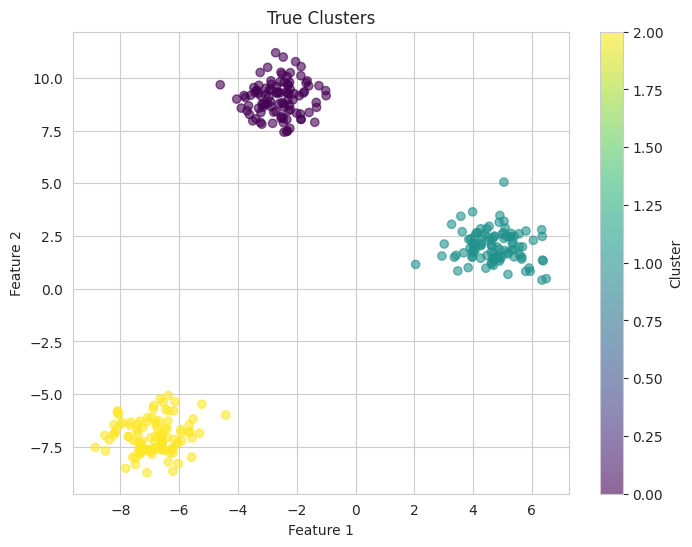

In [9]:
# Generate sample data
X, y_true = make_blobs(n_samples=300, centers=3, n_features=2, 
                       cluster_std=0.8, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.6)
plt.title('True Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

## Fit Custom GMM and Plot

Train the custom `GMM_EM` model on the synthetic data and visualize cluster assignments and centroids.

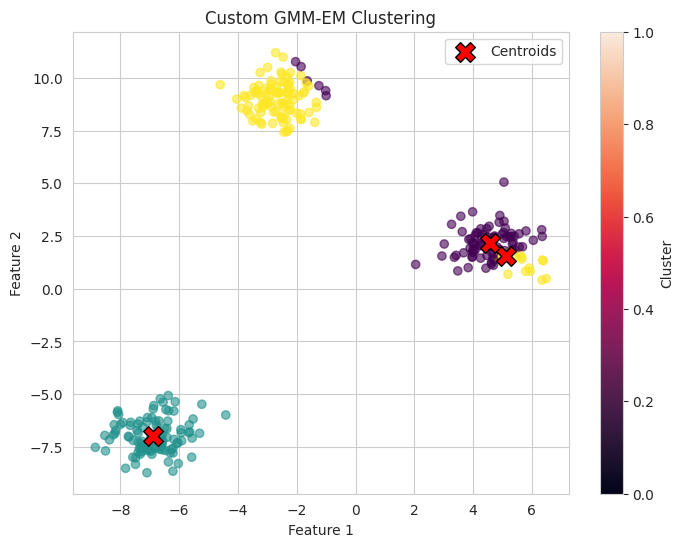

In [10]:
# Fit our custom GMM
gmm_custom = GMM_EM(n_components=3, max_iter=100, random_state=42)
gmm_custom.fit(X)
labels_custom = gmm_custom.predict(X)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', alpha=0.6)
plt.scatter(gmm_custom.means[:, 0], gmm_custom.means[:, 1], 
           c='red', marker='X', s=200, edgecolors='black', label='Centroids')
plt.title('Custom GMM-EM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

## Log-Likelihood Convergence

Plot the EM log-likelihood across iterations to confirm convergence behavior.

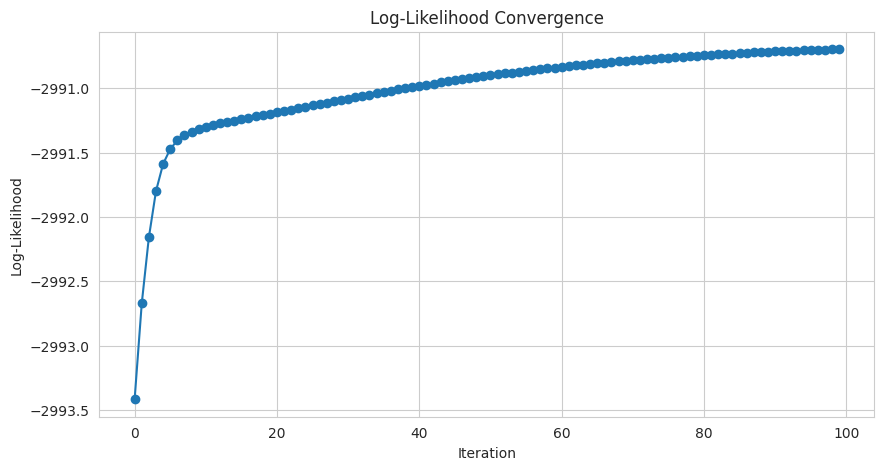

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(gmm_custom.log_likelihoods, marker='o')
plt.title('Log-Likelihood Convergence')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

## Compare with scikit-learn GMM

Fit `GaussianMixture` and visualize side-by-side with the custom implementation.

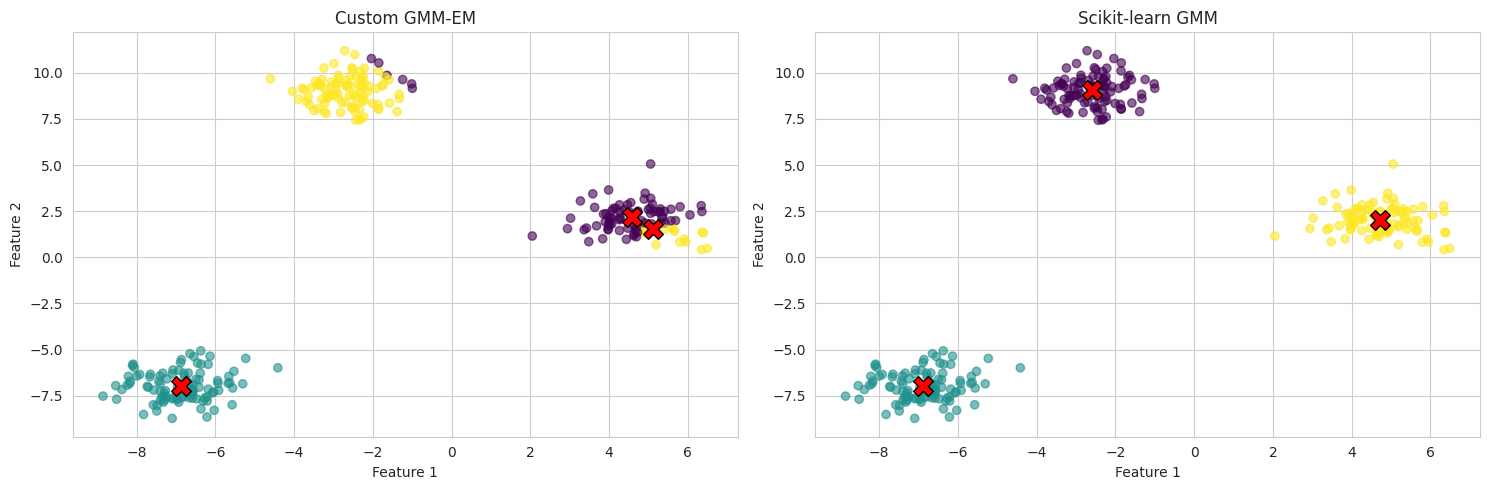

In [12]:
# Fit sklearn GMM
gmm_sklearn = GaussianMixture(n_components=3, random_state=42)
gmm_sklearn.fit(X)
labels_sklearn = gmm_sklearn.predict(X)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Custom implementation
axes[0].scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', alpha=0.6)
axes[0].scatter(gmm_custom.means[:, 0], gmm_custom.means[:, 1], 
               c='red', marker='X', s=200, edgecolors='black')
axes[0].set_title('Custom GMM-EM')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Sklearn implementation
axes[1].scatter(X[:, 0], X[:, 1], c=labels_sklearn, cmap='viridis', alpha=0.6)
axes[1].scatter(gmm_sklearn.means_[:, 0], gmm_sklearn.means_[:, 1], 
               c='red', marker='X', s=200, edgecolors='black')
axes[1].set_title('Scikit-learn GMM')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## Gaussian Ellipses Visualization

Overlay covariance ellipses (2σ) to inspect component shapes and orientations.

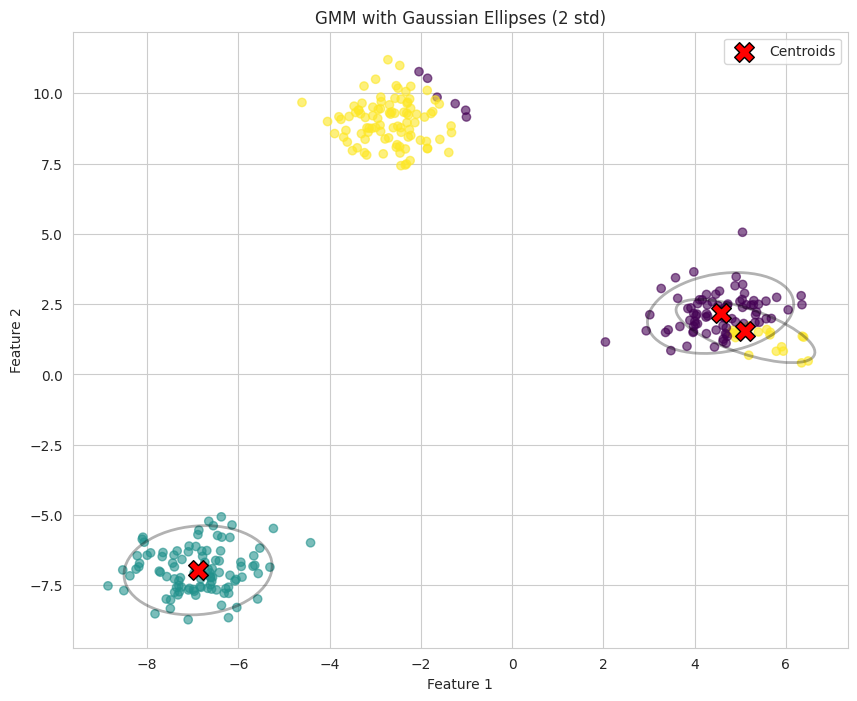

In [13]:
from matplotlib.patches import Ellipse

def plot_gaussian_ellipses(means, covariances, ax, n_std=2.0, alpha=0.3):
    """Plot Gaussian ellipses for each component"""
    for mean, cov in zip(means, covariances):
        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 2 * n_std * np.sqrt(eigenvalues)
        
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                         alpha=alpha, edgecolor='black', facecolor='none', linewidth=2)
        ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', alpha=0.6)
ax.scatter(gmm_custom.means[:, 0], gmm_custom.means[:, 1], 
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
plot_gaussian_ellipses(gmm_custom.means, gmm_custom.covariances, ax)
ax.set_title('GMM with Gaussian Ellipses (2 std)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()
plt.show()

## Model Selection: BIC and AIC over Components

Sweep the number of components (k) and plot BIC/AIC curves to select k; print optimal values.

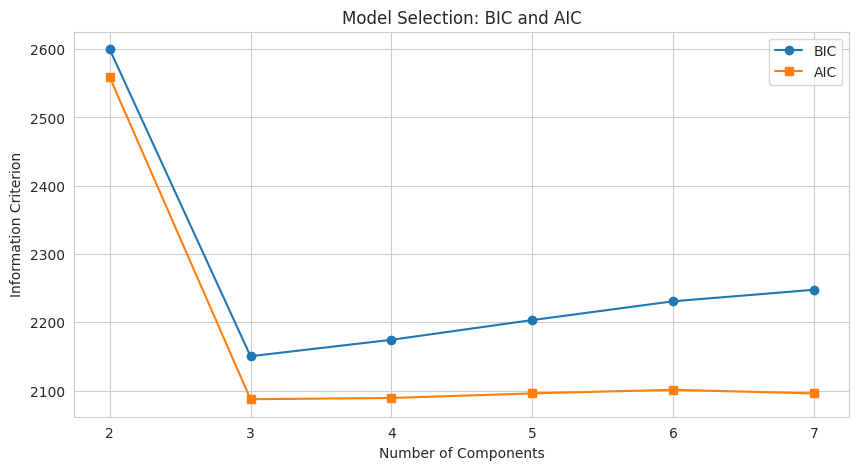

Optimal number of components (BIC): 3
Optimal number of components (AIC): 3


In [14]:
# Test different numbers of components
n_components_range = range(2, 8)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.plot(n_components_range, aic_scores, marker='s', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.title('Model Selection: BIC and AIC')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of components (BIC): {n_components_range[np.argmin(bic_scores)]}")
print(f"Optimal number of components (AIC): {n_components_range[np.argmin(aic_scores)]}")

# Experiment 4: GMM after PCA

- Use same principal component variations as Experiment 3 (2, 5, 10, 15, 20)
- Compare all covariance types for each dimension
- Analyze how dimensionality affects optimal covariance type

## PCA Implementation (from PCA_&_Autoencoder.ipynb)

In [15]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None  # Principal components
        self.mean = None
        self.explained_variance = None  # Eigenvalues
        self.explained_variance_ratio = None  # Ratio of variance explained

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.explained_variance = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        self.components = sorted_eigenvectors[:, :self.n_components]
        total_variance = np.sum(self.explained_variance)
        self.explained_variance_ratio = (
            self.explained_variance[:self.n_components] / total_variance
        )
        return self

    def transform(self, X):
        if self.components is None:
            raise Exception("PCA must be fit before transform")
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components.T) + self.mean

    def get_reconstruction_error(self, X):
        X_transformed = self.transform(X)
        X_reconstructed = self.inverse_transform(X_transformed)
        mse = np.mean(np.sum((X - X_reconstructed) ** 2, axis=1))
        return mse

## Load and Prepare Data for Experiment 4

Use the Breast Cancer Wisconsin dataset and standardize features.

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load dataset
bc_data = load_breast_cancer()
df_bc = pd.DataFrame(bc_data.data, columns=bc_data.feature_names)
# Add diagnosis (target)
df_bc['diagnosis'] = bc_data.target

# Features and standardization
X_bc = df_bc.drop(columns=['diagnosis']).values
X_bc = (X_bc - X_bc.mean(axis=0)) / X_bc.std(axis=0)

# Ground truth mapping (malignant=1, benign=0)
y_true_bc = (df_bc['diagnosis'] == 0).astype(int).values

# Helper: purity score
def purity_score(y_true, y_pred):
    total = 0
    for cluster in np.unique(y_pred):
        indices = y_pred == cluster
        true_labels = y_true[indices]
        total += np.max(np.bincount(true_labels))
    return total / len(y_true)

## Run GMM after PCA: Compare Covariance Types across PCA Dimensions

In [17]:
import time

n_components_list = [2, 5, 10, 15, 20]
covariance_types = ['full', 'tied', 'diagonal', 'spherical']
clusters = 2  # Breast cancer has two classes

results = {
    'pca_components': [],
    'covariance_type': [],
    'bic': [],
    'aic': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'ari': [],
    'nmi': [],
    'purity': [],
    'time': []
}

print("Running Experiment 4: GMM after PCA")

for n_comp in n_components_list:
    print(f"\nTesting PCA with {n_comp} components...")
    pca = PCA(n_components=n_comp)
    pca.fit(X_bc)
    X_pca = pca.transform(X_bc)

    for cov in covariance_types:
        start = time.time()
        gmm = GMM_EM(n_components=clusters, covariance_type=cov, max_iter=100, tol=1e-4, random_state=42)
        gmm.fit(X_pca)
        labels = gmm.predict(X_pca)
        elapsed = time.time() - start

        # Internal metrics
        def _silhouette(X, labels):
            n = X.shape[0]
            unique_labels = np.unique(labels)
            vals = []
            for i in range(n):
                same = labels == labels[i]
                a = np.mean(np.linalg.norm(X[i] - X[same], axis=1))
                b = np.inf
                for lab in unique_labels:
                    if lab == labels[i]:
                        continue
                    pts = X[labels == lab]
                    dist = np.mean(np.linalg.norm(X[i] - pts, axis=1))
                    b = min(b, dist)
                vals.append((b - a) / max(a, b))
            return float(np.mean(vals))

        def _davies_bouldin(X, labels, centroids):
            k = len(centroids)
            scatter = np.zeros(k)
            for i in range(k):
                pts = X[labels == i]
                scatter[i] = np.mean(np.linalg.norm(pts - centroids[i], axis=1)) if len(pts) else 0.0
            db = 0.0
            for i in range(k):
                max_ratio = 0.0
                for j in range(k):
                    if i != j:
                        dist = np.linalg.norm(centroids[i] - centroids[j])
                        ratio = (scatter[i] + scatter[j]) / (dist + 1e-10)
                        max_ratio = max(max_ratio, ratio)
                db += max_ratio
            return db / max(k, 1)

        def _calinski_harabasz(X, labels, centroids):
            n = X.shape[0]
            k = len(centroids)
            overall = np.mean(X, axis=0)
            between = 0.0
            within = 0.0
            for i in range(k):
                pts = X[labels == i]
                ni = len(pts)
                between += ni * np.sum((centroids[i] - overall) ** 2)
                within += np.sum((pts - centroids[i]) ** 2)
            return (between / max(k - 1, 1)) / (within / max(n - k, 1))

        # Compute centroids in PCA space
        k = clusters
        centroids = np.zeros((k, X_pca.shape[1]))
        for c in range(k):
            pts = X_pca[labels == c]
            centroids[c] = np.mean(pts, axis=0) if len(pts) else np.zeros(X_pca.shape[1])

        sil = _silhouette(X_pca, labels)
        db = _davies_bouldin(X_pca, labels, centroids)
        ch = _calinski_harabasz(X_pca, labels, centroids)

        ari = adjusted_rand_score(y_true_bc, labels)
        nmi = normalized_mutual_info_score(y_true_bc, labels)
        pur = purity_score(y_true_bc, labels)

        bic = float(gmm.bic(X_pca))
        aic = float(gmm.aic(X_pca))

        results['pca_components'].append(n_comp)
        results['covariance_type'].append(cov)
        results['bic'].append(bic)
        results['aic'].append(aic)
        results['silhouette'].append(float(sil))
        results['davies_bouldin'].append(float(db))
        results['calinski_harabasz'].append(float(ch))
        results['ari'].append(float(ari))
        results['nmi'].append(float(nmi))
        results['purity'].append(float(pur))
        results['time'].append(float(elapsed))

        print(f"  {cov:<8} | BIC: {bic:.2f} | AIC: {aic:.2f} | Silhouette: {sil:.3f} | Time: {elapsed:.2f}s")

Running Experiment 4: GMM after PCA

Testing PCA with 2 components...
Converged at iteration 35
Converged at iteration 35
  full     | BIC: 5414.72 | AIC: 5366.94 | Silhouette: 0.460 | Time: 5.13s
  full     | BIC: 5414.72 | AIC: 5366.94 | Silhouette: 0.460 | Time: 5.13s
Converged at iteration 13
  tied     | BIC: 5610.69 | AIC: 5575.94 | Silhouette: 0.490 | Time: 1.89s
Converged at iteration 13
  tied     | BIC: 5610.69 | AIC: 5575.94 | Silhouette: 0.490 | Time: 1.89s
Converged at iteration 37
  diagonal | BIC: 5417.28 | AIC: 5378.18 | Silhouette: 0.466 | Time: 0.78s
Converged at iteration 37
  diagonal | BIC: 5417.28 | AIC: 5378.18 | Silhouette: 0.466 | Time: 0.78s
Converged at iteration 27
  spherical | BIC: 5407.88 | AIC: 5377.47 | Silhouette: 0.470 | Time: 0.40s

Testing PCA with 5 components...
Converged at iteration 27
  spherical | BIC: 5407.88 | AIC: 5377.47 | Silhouette: 0.470 | Time: 0.40s

Testing PCA with 5 components...
Converged at iteration 36
Converged at iteration 36


## Results Table: GMM after PCA

In [18]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df = results_df.round(4)
results_df

,pca_components,covariance_type,bic,aic,silhouette,davies_bouldin,calinski_harabasz,ari,nmi,purity,time
0,2,full,5414.7210,5366.9383,0.4598,0.9218,476.9850,0.6325,0.5241,0.8981,5.1337
1,2,tied,5610.6865,5575.9355,0.4897,0.7932,424.6027,0.4204,0.4235,0.8295,1.8853
2,2,diagonal,5417.2759,5378.1810,0.4657,0.9068,496.8494,0.6213,0.5102,0.8946,0.7782
3,2,spherical,5407.8775,5377.4703,0.4700,0.9095,497.2700,0.6156,0.4997,0.8928,0.4020
4,5,full,11203.8904,11025.7913,0.2643,1.3996,217.6655,0.4015,0.3629,0.8172,7.1107
5,5,tied,11571.0972,11458.1563,0.3749,1.0878,235.7678,0.3724,0.3864,0.8120,4.0860
6,5,diagonal,11377.8235,11286.6020,0.2756,1.4208,208.4062,0.4150,0.3716,0.8225,0.8758
7,5,spherical,11643.8614,11587.3910,0.3760,1.2070,318.5817,0.6318,0.5077,0.8981,0.6978
8,10,full,16751.0428,16181.9945,0.2030,1.5712,165.9914,0.3493,0.3674,0.7961,21.3856
9,10,tied,17220.3446,16890.2097,0.3420,1.2587,219.5553,0.4713,0.4316,0.8471,19.1643


## Visualization: BIC/AIC Across PCA Dimensions and Covariance Types

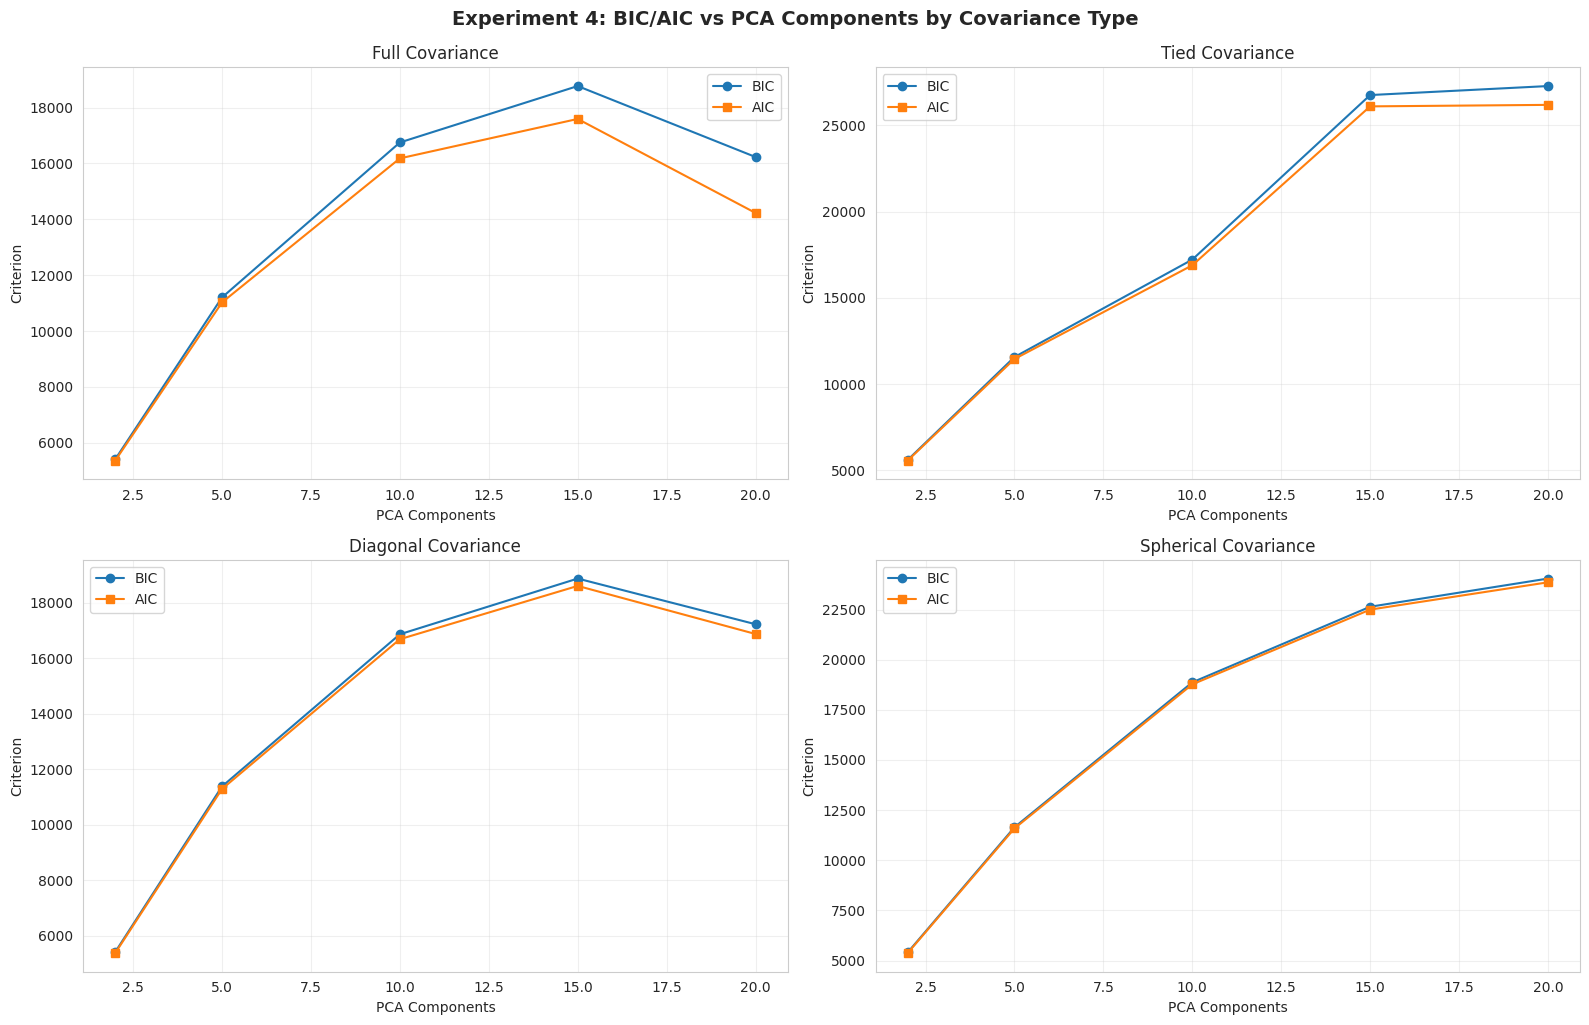

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, cov in enumerate(covariance_types):
    mask = results_df['covariance_type'] == cov
    dims = results_df.loc[mask, 'pca_components']
    bic_vals = results_df.loc[mask, 'bic']
    aic_vals = results_df.loc[mask, 'aic']

    axes[idx].plot(dims, bic_vals, marker='o', label='BIC')
    axes[idx].plot(dims, aic_vals, marker='s', label='AIC')
    axes[idx].set_title(f'{cov.capitalize()} Covariance')
    axes[idx].set_xlabel('PCA Components')
    axes[idx].set_ylabel('Criterion')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Experiment 4: BIC/AIC vs PCA Components by Covariance Type', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Analysis: Optimal Covariance per Dimension

Determine the best covariance type for each PCA dimension and overall trends.

In [20]:
print("EXPERIMENT 4: ANALYSIS")

# Best covariance by dimension using BIC
best_by_dim = {}
for n_comp in n_components_list:
    subset = results_df[results_df['pca_components'] == n_comp]
    best_idx = subset['bic'].idxmin()
    best_cov = subset.loc[best_idx, 'covariance_type']
    best_bic = subset.loc[best_idx, 'bic']
    best_by_dim[n_comp] = (best_cov, best_bic)
    print(f"PCA {n_comp:>2} components -> Best covariance: {best_cov} (BIC={best_bic:.2f})")

# Count wins per covariance type
wins = {cov: 0 for cov in covariance_types}
for n_comp, (cov, _) in best_by_dim.items():
    wins[cov] += 1

print("\nWins by covariance type:")
for cov in covariance_types:
    print(f"  {cov:<8}: {wins[cov]} wins")

# Overall recommendation: lowest average BIC
avg_bic_by_cov = results_df.groupby('covariance_type')['bic'].mean().sort_values()
best_overall_cov = avg_bic_by_cov.index[0]
print("\nOverall best covariance type by average BIC:")
for cov, val in avg_bic_by_cov.items():
    print(f"  {cov:<8}: {val:.2f}")

# Dimensionality effect insight: best dimension by BIC across any covariance
avg_bic_by_dim = results_df.groupby('pca_components')['bic'].mean().sort_values()
best_dim = avg_bic_by_dim.index[0]
print("\nAverage BIC by PCA components:")
for dim, val in avg_bic_by_dim.items():
    print(f"  {dim:>2} components: {val:.2f}")

print("\nCONCLUSION:")
print(f"Recommended covariance type overall: {best_overall_cov}")
print(f"Recommended PCA dimensionality (by average BIC): {best_dim} components")
print("Consider external metrics (ARI/NMI/Purity) alongside BIC for final selection.")

EXPERIMENT 4: ANALYSIS
PCA  2 components -> Best covariance: spherical (BIC=5407.88)
PCA  5 components -> Best covariance: full (BIC=11203.89)
PCA 10 components -> Best covariance: full (BIC=16751.04)
PCA 15 components -> Best covariance: full (BIC=18770.95)
PCA 20 components -> Best covariance: full (BIC=16231.01)

Wins by covariance type:
  full    : 4 wins
  tied    : 0 wins
  diagonal: 0 wins
  spherical: 1 wins

Overall best covariance type by average BIC:
  full    : 13674.32
  diagonal: 13948.98
  spherical: 16521.34
  tied    : 17687.17

Average BIC by PCA components:
   2 components: 5462.64
   5 components: 11449.17
  10 components: 17425.37
  20 components: 21193.99
  15 components: 21758.58

CONCLUSION:
Recommended covariance type overall: full
Recommended PCA dimensionality (by average BIC): 2 components
Consider external metrics (ARI/NMI/Purity) alongside BIC for final selection.


# Experiment 6: GMM after Autoencoder

- Use same bottleneck dimensions as Experiment 5 (2, 5, 10, 15, 20)
- Compare with PCA-GMM results from Experiment 4
- Determine which dimensionality reduction technique works best with GMM

## Autoencoder Implementation (from PCA_&_Autoencoder.ipynb)

In [21]:
# Activation functions
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

In [22]:
class Autoencoder:
    def __init__(self, input_dim, hidden_layers, bottleneck_dim, activation='relu', learning_rate=0.01, lambda_l2=0.01):
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.lambda_l2 = lambda_l2

        if activation == 'relu':
            self.act = relu
            self.act_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.act = sigmoid
            self.act_derivative = sigmoid_derivative
        elif activation == 'tanh':
            self.act = tanh
            self.act_derivative = tanh_derivative
        else:
            raise Exception("Unsupported activation")

        layer_dims = [input_dim] + hidden_layers + [bottleneck_dim] + hidden_layers[::-1] + [input_dim]
        self.weights = []
        self.biases = []

        for i in range(len(layer_dims) - 1):
            n_in = layer_dims[i]
            n_out = layer_dims[i + 1]
            scale = np.sqrt(2.0 / n_in)
            W = np.random.randn(n_in, n_out) * scale
            b = np.zeros((1, n_out))
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        self.Z_store = []
        self.A_store = [X]
        A = X

        for i in range(len(self.weights) - 1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.act(Z)
            self.Z_store.append(Z)
            self.A_store.append(A)

        last_idx = len(self.weights) - 1
        Z_final = np.dot(A, self.weights[last_idx]) + self.biases[last_idx]
        A_final = Z_final
        self.Z_store.append(Z_final)
        self.A_store.append(A_final)
        return A_final

    def backward(self, X, Y_pred):
        m = X.shape[0]
        grads_W = []
        grads_b = []
        dZ = (Y_pred - X) / m
        num_layers = len(self.weights)

        for i in reversed(range(num_layers)):
            A_prev = self.A_store[i]
            W = self.weights[i]
            dW = np.dot(A_prev.T, dZ) + (self.lambda_l2 * W)
            db = np.sum(dZ, axis=0, keepdims=True)
            grads_W.insert(0, dW)
            grads_b.insert(0, db)

            if(i > 0):
                dZ = np.dot(dZ, W.T)
                dZ = dZ * self.act_derivative(self.Z_store[i - 1])
        return grads_W, grads_b

    def update_parameters(self, grads_W, grads_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_W[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    def get_bottleneck(self, X):
        bottleneck_layer_idx = (len(self.weights) // 2)
        A = X
        for i in range(bottleneck_layer_idx):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.act(Z)
        return A

    def fit(self, X, epochs=100, batch_size=32, verbose=True):
        """Training loop with Mini-Batch GD and Learning Rate Scheduling."""
        loss_history = []

        for epoch in range(epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            epoch_loss = 0

            for start_idx in range(0, X.shape[0], batch_size):
                end_idx = min(start_idx + batch_size, X.shape[0])
                batch_X = X_shuffled[start_idx:end_idx]

                Y_pred = self.forward(batch_X)
                mse_loss = np.mean((batch_X - Y_pred) ** 2)
                l2_loss = 0
                for W in self.weights:
                    l2_loss += np.sum(W ** 2)
                total_loss = mse_loss + (0.5 * self.lambda_l2 * l2_loss)
                epoch_loss += total_loss

                grads_W, grads_b = self.backward(batch_X, Y_pred)
                self.update_parameters(grads_W, grads_b)

            avg_loss = epoch_loss / (X.shape[0] / batch_size)
            loss_history.append(avg_loss)

            if epoch % 10 == 0 and epoch > 0:
                self.learning_rate *= 0.95

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

        return loss_history

## Run GMM after Autoencoder: Compare Covariance Types across Bottleneck Dimensions

In [23]:
import time

bottleneck_dims = [2, 5, 10, 15, 20]
covariance_types_ae = ['full', 'tied', 'diagonal', 'spherical']
clusters_ae = 2

results_ae = {
    'bottleneck_dim': [],
    'covariance_type': [],
    'bic': [],
    'aic': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'ari': [],
    'nmi': [],
    'purity': [],
    'training_time': [],
    'gmm_time': []
}

print("Running Experiment 6: GMM after Autoencoder")

for bottleneck in bottleneck_dims:
    print(f"\nTraining Autoencoder with bottleneck dimension {bottleneck}...")
    
    # Train Autoencoder
    train_start = time.time()
    ae = Autoencoder(
        input_dim=X_bc.shape[1],
        hidden_layers=[20, 10],
        bottleneck_dim=bottleneck,
        activation='relu',
        learning_rate=0.01,
        lambda_l2=0.01
    )
    ae.fit(X_bc, epochs=50, batch_size=32, verbose=False)
    X_ae = ae.get_bottleneck(X_bc)
    train_elapsed = time.time() - train_start
    print(f"  Autoencoder training time: {train_elapsed:.2f}s")
    
    for cov in covariance_types_ae:
        gmm_start = time.time()
        gmm = GMM_EM(n_components=clusters_ae, covariance_type=cov, max_iter=100, tol=1e-4, random_state=42)
        gmm.fit(X_ae)
        labels = gmm.predict(X_ae)
        gmm_elapsed = time.time() - gmm_start

        # Internal metrics
        def _silhouette(X, labels):
            n = X.shape[0]
            unique_labels = np.unique(labels)
            vals = []
            for i in range(n):
                same = labels == labels[i]
                a = np.mean(np.linalg.norm(X[i] - X[same], axis=1))
                b = np.inf
                for lab in unique_labels:
                    if lab == labels[i]:
                        continue
                    pts = X[labels == lab]
                    dist = np.mean(np.linalg.norm(X[i] - pts, axis=1))
                    b = min(b, dist)
                vals.append((b - a) / max(a, b))
            return float(np.mean(vals))

        def _davies_bouldin(X, labels, centroids):
            k = len(centroids)
            scatter = np.zeros(k)
            for i in range(k):
                pts = X[labels == i]
                scatter[i] = np.mean(np.linalg.norm(pts - centroids[i], axis=1)) if len(pts) else 0.0
            db = 0.0
            for i in range(k):
                max_ratio = 0.0
                for j in range(k):
                    if i != j:
                        dist = np.linalg.norm(centroids[i] - centroids[j])
                        ratio = (scatter[i] + scatter[j]) / (dist + 1e-10)
                        max_ratio = max(max_ratio, ratio)
                db += max_ratio
            return db / max(k, 1)

        def _calinski_harabasz(X, labels, centroids):
            n = X.shape[0]
            k = len(centroids)
            overall = np.mean(X, axis=0)
            between = 0.0
            within = 0.0
            for i in range(k):
                pts = X[labels == i]
                ni = len(pts)
                between += ni * np.sum((centroids[i] - overall) ** 2)
                within += np.sum((pts - centroids[i]) ** 2)
            return (between / max(k - 1, 1)) / (within / max(n - k, 1))

        # Compute centroids
        k = clusters_ae
        centroids = np.zeros((k, X_ae.shape[1]))
        for c in range(k):
            pts = X_ae[labels == c]
            centroids[c] = np.mean(pts, axis=0) if len(pts) else np.zeros(X_ae.shape[1])

        sil = _silhouette(X_ae, labels)
        db = _davies_bouldin(X_ae, labels, centroids)
        ch = _calinski_harabasz(X_ae, labels, centroids)

        ari = adjusted_rand_score(y_true_bc, labels)
        nmi = normalized_mutual_info_score(y_true_bc, labels)
        pur = purity_score(y_true_bc, labels)

        bic = float(gmm.bic(X_ae))
        aic = float(gmm.aic(X_ae))

        results_ae['bottleneck_dim'].append(bottleneck)
        results_ae['covariance_type'].append(cov)
        results_ae['bic'].append(bic)
        results_ae['aic'].append(aic)
        results_ae['silhouette'].append(float(sil))
        results_ae['davies_bouldin'].append(float(db))
        results_ae['calinski_harabasz'].append(float(ch))
        results_ae['ari'].append(float(ari))
        results_ae['nmi'].append(float(nmi))
        results_ae['purity'].append(float(pur))
        results_ae['training_time'].append(float(train_elapsed))
        results_ae['gmm_time'].append(float(gmm_elapsed))

        print(f"  {cov:<8} | BIC: {bic:.2f} | AIC: {aic:.2f} | Silhouette: {sil:.3f} | GMM Time: {gmm_elapsed:.2f}s")

print("\nExperiment 6 Complete!")

Running Experiment 6: GMM after Autoencoder

Training Autoencoder with bottleneck dimension 2...
  Autoencoder training time: 0.33s
  Autoencoder training time: 0.33s
Converged at iteration 10
Converged at iteration 10
  full     | BIC: -4303.88 | AIC: -4351.67 | Silhouette: -0.318 | GMM Time: 1.46s
  full     | BIC: -4303.88 | AIC: -4351.67 | Silhouette: -0.318 | GMM Time: 1.46s
Converged at iteration 33
Converged at iteration 33
  tied     | BIC: -3782.46 | AIC: -3817.21 | Silhouette: 0.707 | GMM Time: 4.68s
  tied     | BIC: -3782.46 | AIC: -3817.21 | Silhouette: 0.707 | GMM Time: 4.68s
Converged at iteration 10
  diagonal | BIC: -4310.39 | AIC: -4349.49 | Silhouette: -0.318 | GMM Time: 0.22s
Converged at iteration 10
  diagonal | BIC: -4310.39 | AIC: -4349.49 | Silhouette: -0.318 | GMM Time: 0.22s
Converged at iteration 18
  spherical | BIC: 1146.54 | AIC: 1116.13 | Silhouette: 0.627 | GMM Time: 0.26s

Training Autoencoder with bottleneck dimension 5...
Converged at iteration 18
  

## Results Table: GMM after Autoencoder

In [24]:
results_ae_df = pd.DataFrame(results_ae)
results_ae_df = results_ae_df.round(4)
results_ae_df

,bottleneck_dim,covariance_type,bic,aic,silhouette,davies_bouldin,calinski_harabasz,ari,nmi,purity,training_time,gmm_time
0,2,full,-4303.8831,-4351.6658,-0.3184,1.1079,10.0653,-0.0197,0.0339,0.6274,0.3280,1.4566
1,2,tied,-3782.4620,-3817.2130,0.7071,0.4605,1343.3703,0.3778,0.3667,0.8137,0.3280,4.6783
2,2,diagonal,-4310.3911,-4349.4861,-0.3184,1.1079,10.0653,-0.0197,0.0339,0.6274,0.3280,0.2175
3,2,spherical,1146.5384,1116.1312,0.6266,0.5396,906.2190,0.6665,0.5514,0.9086,0.3280,0.2620
4,5,full,-12628.1117,-12806.2108,0.3540,0.9120,321.9234,0.3708,0.3513,0.8049,0.2419,1.3811
5,5,tied,-8231.2050,-8344.1458,0.6266,0.6097,786.5160,0.3771,0.3900,0.8137,0.2419,3.0503
6,5,diagonal,-12280.8354,-12372.0569,0.3540,0.9120,321.9234,0.3708,0.3513,0.8049,0.2419,0.2324
7,5,spherical,5143.6447,5087.1743,0.5969,0.6635,803.7427,0.6772,0.5537,0.9121,0.2419,0.2037
8,10,full,-8585.3468,-9154.3951,0.2693,1.7060,128.4413,0.1794,0.1097,0.7170,0.2611,6.0485
9,10,tied,-4147.8840,-4478.0189,0.4339,1.1269,168.8504,0.2232,0.2331,0.7504,0.2611,5.4093


## Visualization: BIC/AIC Across Bottleneck Dimensions and Covariance Types

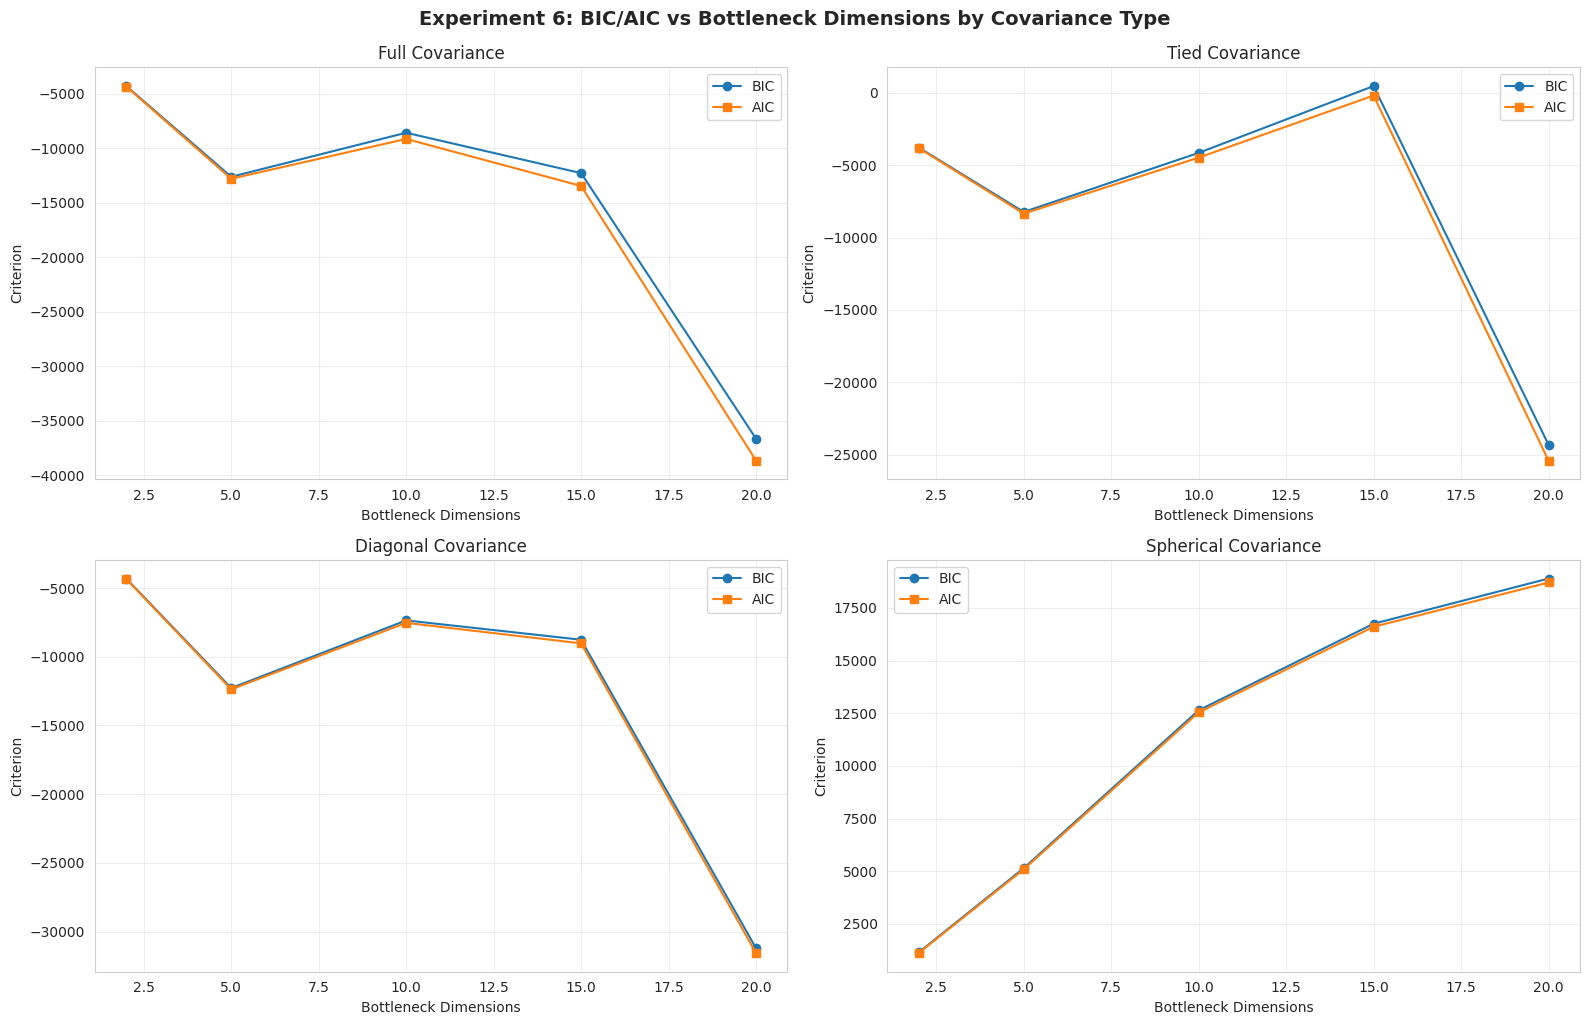

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, cov in enumerate(covariance_types_ae):
    mask = results_ae_df['covariance_type'] == cov
    dims = results_ae_df.loc[mask, 'bottleneck_dim']
    bic_vals = results_ae_df.loc[mask, 'bic']
    aic_vals = results_ae_df.loc[mask, 'aic']

    axes[idx].plot(dims, bic_vals, marker='o', label='BIC')
    axes[idx].plot(dims, aic_vals, marker='s', label='AIC')
    axes[idx].set_title(f'{cov.capitalize()} Covariance')
    axes[idx].set_xlabel('Bottleneck Dimensions')
    axes[idx].set_ylabel('Criterion')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Experiment 6: BIC/AIC vs Bottleneck Dimensions by Covariance Type', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Analysis: Optimal Covariance per Bottleneck Dimension

In [26]:
print("EXPERIMENT 6: ANALYSIS")

# Best covariance by bottleneck dimension using BIC
best_by_bottleneck = {}
for bottleneck in bottleneck_dims:
    subset = results_ae_df[results_ae_df['bottleneck_dim'] == bottleneck]
    best_idx = subset['bic'].idxmin()
    best_cov = subset.loc[best_idx, 'covariance_type']
    best_bic = subset.loc[best_idx, 'bic']
    best_by_bottleneck[bottleneck] = (best_cov, best_bic)
    print(f"Bottleneck {bottleneck:>2} dims -> Best covariance: {best_cov} (BIC={best_bic:.2f})")

# Count wins per covariance type
wins_ae = {cov: 0 for cov in covariance_types_ae}
for bottleneck, (cov, _) in best_by_bottleneck.items():
    wins_ae[cov] += 1

print("\nWins by covariance type:")
for cov in covariance_types_ae:
    print(f"  {cov:<8}: {wins_ae[cov]} wins")

# Overall recommendation: lowest average BIC
avg_bic_by_cov_ae = results_ae_df.groupby('covariance_type')['bic'].mean().sort_values()
best_overall_cov_ae = avg_bic_by_cov_ae.index[0]
print("\nOverall best covariance type by average BIC:")
for cov, val in avg_bic_by_cov_ae.items():
    print(f"  {cov:<8}: {val:.2f}")

# Dimensionality effect insight
avg_bic_by_bottleneck = results_ae_df.groupby('bottleneck_dim')['bic'].mean().sort_values()
best_bottleneck = avg_bic_by_bottleneck.index[0]
print("\nAverage BIC by bottleneck dimensions:")
for dim, val in avg_bic_by_bottleneck.items():
    print(f"  {dim:>2} dimensions: {val:.2f}")

print("\nCONCLUSION:")
print(f"Recommended covariance type overall: {best_overall_cov_ae}")
print(f"Recommended bottleneck dimensionality (by average BIC): {best_bottleneck} dimensions")
print("Consider external metrics (ARI/NMI/Purity) alongside BIC for final selection.")

EXPERIMENT 6: ANALYSIS
Bottleneck  2 dims -> Best covariance: diagonal (BIC=-4310.39)
Bottleneck  5 dims -> Best covariance: full (BIC=-12628.11)
Bottleneck 10 dims -> Best covariance: full (BIC=-8585.35)
Bottleneck 15 dims -> Best covariance: full (BIC=-12287.51)
Bottleneck 20 dims -> Best covariance: full (BIC=-36643.41)

Wins by covariance type:
  full    : 4 wins
  tied    : 0 wins
  diagonal: 1 wins
  spherical: 0 wins

Overall best covariance type by average BIC:
  full    : -14889.65
  diagonal: -12783.78
  tied    : -8001.00
  spherical: 10914.47

Average BIC by bottleneck dimensions:
  20 dimensions: -18317.00
   5 dimensions: -6999.13
   2 dimensions: -2812.55
  10 dimensions: -1862.62
  15 dimensions: -958.66

CONCLUSION:
Recommended covariance type overall: full
Recommended bottleneck dimensionality (by average BIC): 20 dimensions
Consider external metrics (ARI/NMI/Purity) alongside BIC for final selection.


## Comparison: PCA-GMM vs Autoencoder-GMM

Compare the results from Experiment 4 (GMM after PCA) and Experiment 6 (GMM after Autoencoder) to determine which dimensionality reduction technique works best with GMM.

In [27]:
print("COMPARISON: PCA-GMM vs Autoencoder-GMM\n")

# Compare average BIC across all configurations
avg_bic_pca = results_df['bic'].mean()
avg_bic_ae = results_ae_df['bic'].mean()

print(f"Average BIC across all configurations:")
print(f"  PCA-GMM:        {avg_bic_pca:.2f}")
print(f"  Autoencoder-GMM: {avg_bic_ae:.2f}")
print(f"  Winner: {'PCA-GMM' if avg_bic_pca < avg_bic_ae else 'Autoencoder-GMM'} (lower is better)\n")

# Compare best configurations
best_pca_idx = results_df['bic'].idxmin()
best_pca_config = results_df.loc[best_pca_idx]
best_ae_idx = results_ae_df['bic'].idxmin()
best_ae_config = results_ae_df.loc[best_ae_idx]

print("Best configuration from PCA-GMM:")
print(f"  Components: {int(best_pca_config['pca_components'])}, Covariance: {best_pca_config['covariance_type']}")
print(f"  BIC: {best_pca_config['bic']:.2f}, AIC: {best_pca_config['aic']:.2f}")
print(f"  Silhouette: {best_pca_config['silhouette']:.3f}, ARI: {best_pca_config['ari']:.3f}, NMI: {best_pca_config['nmi']:.3f}\n")

print("Best configuration from Autoencoder-GMM:")
print(f"  Bottleneck: {int(best_ae_config['bottleneck_dim'])}, Covariance: {best_ae_config['covariance_type']}")
print(f"  BIC: {best_ae_config['bic']:.2f}, AIC: {best_ae_config['aic']:.2f}")
print(f"  Silhouette: {best_ae_config['silhouette']:.3f}, ARI: {best_ae_config['ari']:.3f}, NMI: {best_ae_config['nmi']:.3f}\n")

print(f"Overall best method: {'PCA-GMM' if best_pca_config['bic'] < best_ae_config['bic'] else 'Autoencoder-GMM'} (by BIC)")

# Compare by dimensionality
print("\n" + "="*60)
print("BIC Comparison by Dimensionality:")
print("="*60)
print(f"{'Dims':<6} {'PCA-GMM (Best)':<25} {'Autoencoder-GMM (Best)':<25} {'Winner'}")
print("-"*60)

for dim in [2, 5, 10, 15, 20]:
    pca_subset = results_df[results_df['pca_components'] == dim]
    ae_subset = results_ae_df[results_ae_df['bottleneck_dim'] == dim]
    
    best_pca_bic = pca_subset['bic'].min()
    best_ae_bic = ae_subset['bic'].min()
    
    pca_cov = pca_subset.loc[pca_subset['bic'].idxmin(), 'covariance_type']
    ae_cov = ae_subset.loc[ae_subset['bic'].idxmin(), 'covariance_type']
    
    winner = "PCA" if best_pca_bic < best_ae_bic else "Autoencoder"
    
    print(f"{dim:<6} {best_pca_bic:.2f} ({pca_cov}){' '*(17-len(pca_cov))} {best_ae_bic:.2f} ({ae_cov}){' '*(17-len(ae_cov))} {winner}")

# External metrics comparison
print("\n" + "="*60)
print("External Metrics Comparison (Best Configurations):")
print("="*60)

metrics = ['ari', 'nmi', 'purity']
print(f"{'Metric':<10} {'PCA-GMM':<15} {'Autoencoder-GMM':<15} {'Winner'}")
print("-"*60)

for metric in metrics:
    pca_val = best_pca_config[metric]
    ae_val = best_ae_config[metric]
    winner = "PCA" if pca_val > ae_val else "Autoencoder"
    print(f"{metric.upper():<10} {pca_val:.4f}{' '*9} {ae_val:.4f}{' '*9} {winner}")

print("\n" + "="*60)
print("FINAL RECOMMENDATION:")
print("="*60)
if best_pca_config['bic'] < best_ae_config['bic']:
    print("PCA is recommended for dimensionality reduction before GMM clustering.")
    print(f"Use {int(best_pca_config['pca_components'])} components with {best_pca_config['covariance_type']} covariance.")
else:
    print("Autoencoder is recommended for dimensionality reduction before GMM clustering.")
    print(f"Use {int(best_ae_config['bottleneck_dim'])} bottleneck dimensions with {best_ae_config['covariance_type']} covariance.")
print("="*60)

COMPARISON: PCA-GMM vs Autoencoder-GMM

Average BIC across all configurations:
  PCA-GMM:        15457.95
  Autoencoder-GMM: -6189.99
  Winner: Autoencoder-GMM (lower is better)

Best configuration from PCA-GMM:
  Components: 2, Covariance: spherical
  BIC: 5407.88, AIC: 5377.47
  Silhouette: 0.470, ARI: 0.616, NMI: 0.500

Best configuration from Autoencoder-GMM:
  Bottleneck: 20, Covariance: full
  BIC: -36643.41, AIC: -38645.94
  Silhouette: 0.352, ARI: 0.805, NMI: 0.711

Overall best method: Autoencoder-GMM (by BIC)

BIC Comparison by Dimensionality:
Dims   PCA-GMM (Best)            Autoencoder-GMM (Best)    Winner
------------------------------------------------------------
2      5407.88 (spherical)         -4310.39 (diagonal)          Autoencoder
5      11203.89 (full)              -12628.11 (full)              Autoencoder
10     16751.04 (full)              -8585.35 (full)              Autoencoder
15     18770.95 (full)              -12287.51 (full)              Autoencoder
20  

## Visualization: Side-by-Side Comparison of PCA-GMM vs Autoencoder-GMM

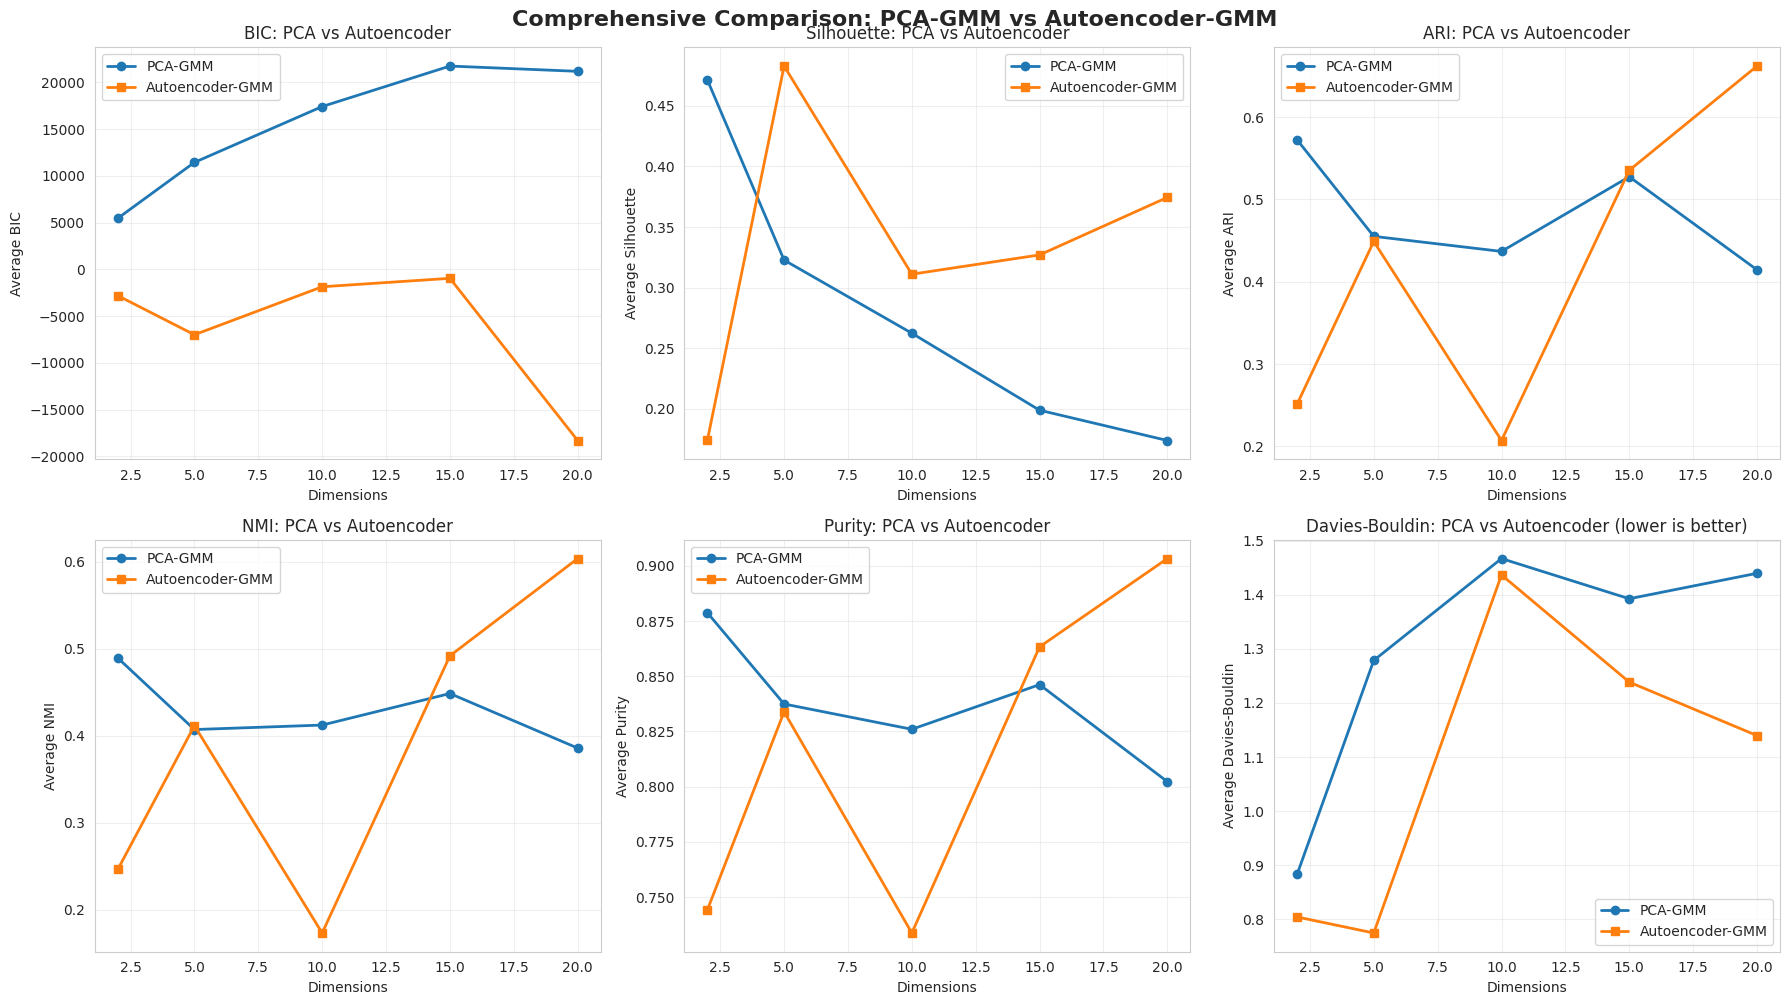

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: BIC comparison by dimension (all covariances)
avg_bic_pca_by_dim = results_df.groupby('pca_components')['bic'].mean()
avg_bic_ae_by_dim = results_ae_df.groupby('bottleneck_dim')['bic'].mean()

axes[0, 0].plot(avg_bic_pca_by_dim.index, avg_bic_pca_by_dim.values, marker='o', label='PCA-GMM', linewidth=2)
axes[0, 0].plot(avg_bic_ae_by_dim.index, avg_bic_ae_by_dim.values, marker='s', label='Autoencoder-GMM', linewidth=2)
axes[0, 0].set_xlabel('Dimensions')
axes[0, 0].set_ylabel('Average BIC')
axes[0, 0].set_title('BIC: PCA vs Autoencoder')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Silhouette comparison
avg_sil_pca_by_dim = results_df.groupby('pca_components')['silhouette'].mean()
avg_sil_ae_by_dim = results_ae_df.groupby('bottleneck_dim')['silhouette'].mean()

axes[0, 1].plot(avg_sil_pca_by_dim.index, avg_sil_pca_by_dim.values, marker='o', label='PCA-GMM', linewidth=2)
axes[0, 1].plot(avg_sil_ae_by_dim.index, avg_sil_ae_by_dim.values, marker='s', label='Autoencoder-GMM', linewidth=2)
axes[0, 1].set_xlabel('Dimensions')
axes[0, 1].set_ylabel('Average Silhouette')
axes[0, 1].set_title('Silhouette: PCA vs Autoencoder')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: ARI comparison
avg_ari_pca_by_dim = results_df.groupby('pca_components')['ari'].mean()
avg_ari_ae_by_dim = results_ae_df.groupby('bottleneck_dim')['ari'].mean()

axes[0, 2].plot(avg_ari_pca_by_dim.index, avg_ari_pca_by_dim.values, marker='o', label='PCA-GMM', linewidth=2)
axes[0, 2].plot(avg_ari_ae_by_dim.index, avg_ari_ae_by_dim.values, marker='s', label='Autoencoder-GMM', linewidth=2)
axes[0, 2].set_xlabel('Dimensions')
axes[0, 2].set_ylabel('Average ARI')
axes[0, 2].set_title('ARI: PCA vs Autoencoder')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: NMI comparison
avg_nmi_pca_by_dim = results_df.groupby('pca_components')['nmi'].mean()
avg_nmi_ae_by_dim = results_ae_df.groupby('bottleneck_dim')['nmi'].mean()

axes[1, 0].plot(avg_nmi_pca_by_dim.index, avg_nmi_pca_by_dim.values, marker='o', label='PCA-GMM', linewidth=2)
axes[1, 0].plot(avg_nmi_ae_by_dim.index, avg_nmi_ae_by_dim.values, marker='s', label='Autoencoder-GMM', linewidth=2)
axes[1, 0].set_xlabel('Dimensions')
axes[1, 0].set_ylabel('Average NMI')
axes[1, 0].set_title('NMI: PCA vs Autoencoder')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Purity comparison
avg_pur_pca_by_dim = results_df.groupby('pca_components')['purity'].mean()
avg_pur_ae_by_dim = results_ae_df.groupby('bottleneck_dim')['purity'].mean()

axes[1, 1].plot(avg_pur_pca_by_dim.index, avg_pur_pca_by_dim.values, marker='o', label='PCA-GMM', linewidth=2)
axes[1, 1].plot(avg_pur_ae_by_dim.index, avg_pur_ae_by_dim.values, marker='s', label='Autoencoder-GMM', linewidth=2)
axes[1, 1].set_xlabel('Dimensions')
axes[1, 1].set_ylabel('Average Purity')
axes[1, 1].set_title('Purity: PCA vs Autoencoder')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Davies-Bouldin comparison
avg_db_pca_by_dim = results_df.groupby('pca_components')['davies_bouldin'].mean()
avg_db_ae_by_dim = results_ae_df.groupby('bottleneck_dim')['davies_bouldin'].mean()

axes[1, 2].plot(avg_db_pca_by_dim.index, avg_db_pca_by_dim.values, marker='o', label='PCA-GMM', linewidth=2)
axes[1, 2].plot(avg_db_ae_by_dim.index, avg_db_ae_by_dim.values, marker='s', label='Autoencoder-GMM', linewidth=2)
axes[1, 2].set_xlabel('Dimensions')
axes[1, 2].set_ylabel('Average Davies-Bouldin')
axes[1, 2].set_title('Davies-Bouldin: PCA vs Autoencoder (lower is better)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comprehensive Comparison: PCA-GMM vs Autoencoder-GMM', fontsize=16, fontweight='bold', y=1.00)
plt.show()